# ПРИМЕНЕНИЕ АЛГОРИТМОВ МАШИННОГО И ГЛУБОКОГО ОБУЧЕНИЯ ДЛЯ ИНДЕНТИФИКАЦИИ СООБЩЕНИЙ ПОТЕНЦИАЛЬНЫХ СУИЦИДЕНТОВ


---






*Загрузка библиотек*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from deeppavlov import build_model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Загрузка данных



*Загрузка файлов из формата JSON*

In [ ]:
data = pd.read_json("RU_dataset_sucides.json")
data.columns = ["Text", "Label"]
data

,Text,Label
0,Бывшая жена угрожает самоубийством Недавно я н...,suicide
1,"Я странный? На меня не влияют комплименты, есл...",non-suicide
2,Наконец-то 2020 год почти закончился... Так чт...,non-suicide
3,"мне нужна помощь, просто помоги мне, я так плачу",suicide
4,"Я так растеряна. Здравствуйте, меня зовут Адам...",suicide
...,...,...
47992,"Я только что увидел забавный мем, прежде чем п...",suicide
47993,"Я боюсь, мне некому рассказать. У меня инфекци...",non-suicide
47994,"Педофилия, членовредительство и мысли о самоуб...",suicide
47995,Я больше не могу справляться. Почти 2 месяца н...,suicide


*Проверка на наличие отсутствующих значений*

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47997 entries, 0 to 47996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    47997 non-null  object
 1   Label   47997 non-null  object
dtypes: object(2)
memory usage: 750.1+ KB


# Предобработка классов

*Проверка сбалансированности выборки*

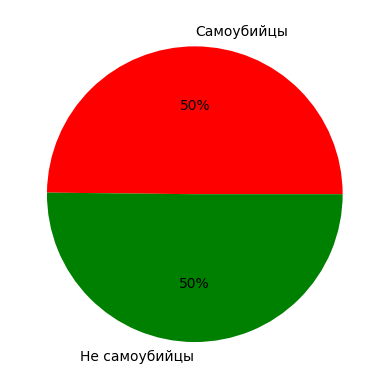

In [ ]:
plt.pie([sum(data['Label'] == "suicide"), sum(data['Label'] == "non-suicide")],
        labels = ["Самоубийцы", "Не самоубийцы"],
        colors = ["red", "green"],
        autopct='%.f%%')
plt.show()

*Сокращение размера выборки*

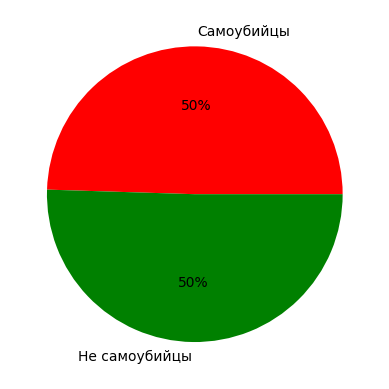

In [ ]:
data = data[:15000]
plt.pie([sum(data['Label'] == "suicide"), sum(data['Label'] == "non-suicide")],
        labels = ["Самоубийцы", "Не самоубийцы"],
        colors = ["red", "green"],
        autopct='%.f%%')
plt.show()

Исходный баланс классов удалось сохранить

# Предобработка данных

*Кодирование меток классов*

In [ ]:
data['binary label'] = data['Label'].replace({
    "suicide": 1,
    "non-suicide": 0
})

<ipython-input-5-d46ba60b823a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['binary label'] = data['Label'].replace({


*Функция для предобработки текстовых данных*

In [ ]:
segmenter = Segmenter()
moprh_vocab = MorphVocab()
emb = NewsEmbedding()
nmt = NewsMorphTagger(emb)
russian_stopwords = stopwords.words('russian')

def preprocess_text(text):
  text = re.sub('[^а-яА-ЯёЁ ]', ' ', text.lower())
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(nmt)
  for token in doc.tokens:
    token.lemmatize(moprh_vocab)
  tokens_clear = [token.lemma for token in doc.tokens if token.lemma not in russian_stopwords]
  return ' '.join(tokens_clear)

*Предобработка текстовых данных*

In [ ]:
data['Clear text'] = data['Text'].apply(preprocess_text)

<ipython-input-7-f9b262b68a38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Clear text'] = data['Text'].apply(preprocess_text)


*Проверка на наличие пустых сообщений*

In [ ]:
data["length"] = data["Clear text"].apply(lambda x: len(x.split()))
print(data['length'].min())
print(data['length'].max())

0
1482


<ipython-input-8-20b8c46db921>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["length"] = data["Clear text"].apply(lambda x: len(x.split()))


Удалим их

In [ ]:
data = data[data["length"] > 0]

*Длины текстов*

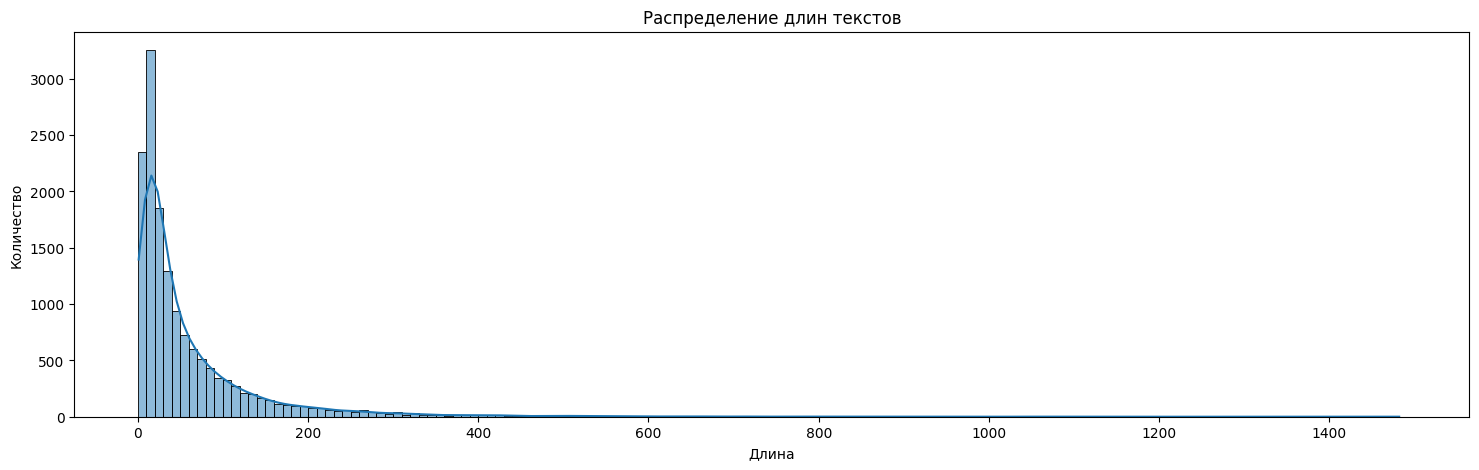

In [ ]:
plt.figure(figsize=(18, 5))
sns.histplot(data['length'], bins=np.arange(0, 1500, 10), kde=True)
plt.title('Распределение длин текстов')
plt.xlabel('Длина')
plt.ylabel('Количество')
plt.show()

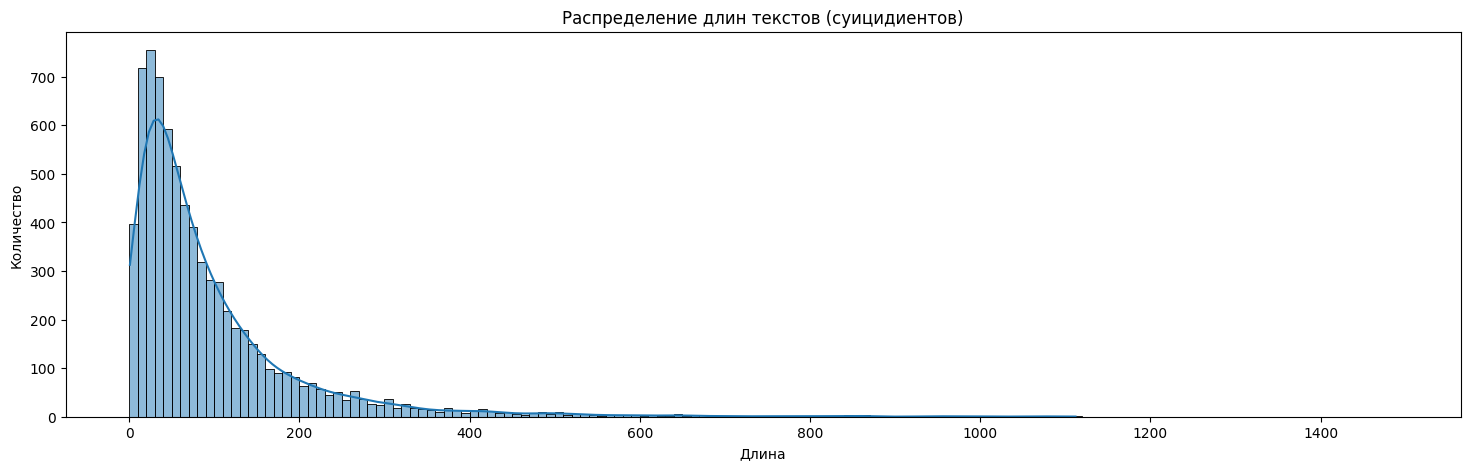

In [ ]:
plt.figure(figsize=(18, 5))
sns.histplot(data[data['binary label']==1]['length'], bins=np.arange(0, 1500, 10), kde=True)
plt.title('Распределение длин текстов (суицидиентов)')
plt.xlabel('Длина')
plt.ylabel('Количество')
plt.show()

In [ ]:
data.groupby('Label').agg({
    'length' : ["min", "max", "median", "mean"]
})

length                        
               min   max median       mean
Label                                     
non-suicide      1  1482   16.0  29.225781
suicide          1  1112   60.0  94.784454

# Семантический анализ

*Загрузка модели для сопоставления метки настроения тексту*

In [ ]:
sentiment_analyzer = build_model('rusentiment_bert', download=True, install=True)

2024-05-25 12:01:43.496 INFO in 'deeppavlov.core.data.utils'['utils'] at line 97: Downloading from http://files.deeppavlov.ai/v1/classifiers/rusentiment_bert/rusentiment_bert_torch.tar.gz to /root/.deeppavlov/models/classifiers/rusentiment_bert_torch.tar.gz
INFO:deeppavlov.core.data.utils:Downloading from http://files.deeppavlov.ai/v1/classifiers/rusentiment_bert/rusentiment_bert_torch.tar.gz to /root/.deeppavlov/models/classifiers/rusentiment_bert_torch.tar.gz
100%|██████████| 1.34G/1.34G [00:41<00:00, 32.5MB/s]
2024-05-25 12:02:25.592 INFO in 'deeppavlov.core.data.utils'['utils'] at line 284: Extracting /root/.deeppavlov/models/classifiers/rusentiment_bert_torch.tar.gz archive into /root/.deeppavlov/models/classifiers/rusentiment_bert_torch
INFO:deeppavlov.core.data.utils:Extracting /root/.deeppavlov/models/classifiers/rusentiment_bert_torch.tar.gz archive into /root/.deeppavlov/models/classifiers/rusentiment_bert_torch
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_dow

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

*Применение модели*

In [ ]:
data['sentiment'] = data['Text'].apply(lambda x: sentiment_analyzer([x])[0])

In [ ]:
data

,Text,Label,binary label,Clear text,length,sentiment
0,Бывшая жена угрожает самоубийством Недавно я н...,suicide,1,бывший жена угрожать самоубийство недавно навс...,65,negative
1,"Я странный? На меня не влияют комплименты, есл...",non-suicide,0,странный влиять комплимент исходить знать очен...,11,positive
2,Наконец-то 2020 год почти закончился... Так чт...,non-suicide,0,год закончиться большой услышать год плохой кл...,11,negative
3,"мне нужна помощь, просто помоги мне, я так плачу",suicide,1,нужный помощь просто помочь плакать,5,negative
4,"Я так растеряна. Здравствуйте, меня зовут Адам...",suicide,1,растерять здравствовать звать адам год страдат...,223,negative
...,...,...,...,...,...,...
14995,у меня 38666 кармы :D я по сути сатана 😈😈😈\n\n...,non-suicide,0,карма суть сатана,3,skip
14996,"16F кто-нибудь хочет поговорить, мне чертовски...",non-suicide,0,хотеть поговорить чертовски скучный это наполн...,13,neutral
14997,Что мне теперь делать? Я наконец-то попробовал...,suicide,1,делать попробовать это сделать думать самоубий...,52,negative
14998,"это все, что ты пишешь, черт возьми. иди и сде...",non-suicide,0,это весь писать черт взять идти сделать свой у...,26,neutral


*Визуализация результатов*

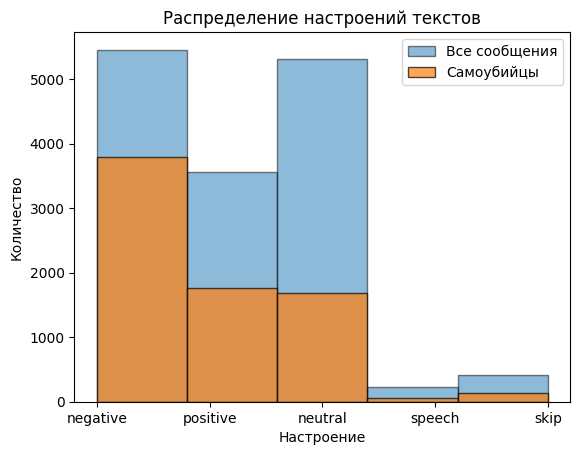

In [ ]:
plt.hist(data['sentiment'], bins=5,edgecolor='black', alpha=0.5, label="Все сообщения")
plt.hist(data[data['binary label']==1]['sentiment'], bins=5,edgecolor='black', alpha=0.7, label="Самоубийцы")
plt.title('Распределение настроений текстов')
plt.xlabel('Настроение')
plt.ylabel('Количество')
plt.legend()
plt.show()

*Проверка наличия корреляции между настроением и классом*

Гипотезы:


*   H0 - переменные независимы (нет взаимосвязи между настроением пользователя и наличием суицидальных мыслей)
*   H1 - переменные не яваляются независимыми (существует взаимосвязь между настроением пользователя и наличием суицидальных мыслей)



In [ ]:
table = pd.crosstab(data['sentiment'], data['Label'])
сhi2, p, dof, freq = chi2_contingency(table)

In [ ]:
сhi2, p

(1635.9090669761335, 0.0)

**p-value меньше 0.05, нулевая гипотеза отвергается**

In [ ]:
table

Label,non-suicide,suicide
sentiment,,
negative,1669,3788
neutral,3628,1678
positive,1811,1757
skip,283,138
speech,165,62


In [ ]:
pd.DataFrame(freq, index=table.index, columns=table.columns)

Label,non-suicide,suicide
sentiment,,
negative,2752.726617,2704.273383
neutral,2676.556245,2629.443755
positive,1799.840310,1768.159690
skip,212.369050,208.630950
speech,114.507778,112.492222


# Построение облака слов

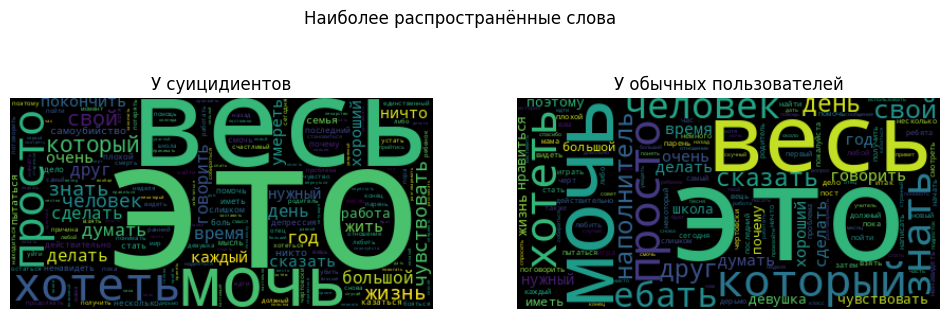

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
wc = WordCloud(collocations=False).generate(' '.join(data[data['binary label'] == 1]['Clear text'].astype(str)))
ax[0].imshow(wc, interpolation='bilinear')
ax[0].set_title('У суицидиентов')
ax[0].axis('off')
wc2 = WordCloud(collocations=False).generate(' '.join(data[data['binary label'] == 0]['Clear text'].astype(str)))
ax[1].imshow(wc2, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('У обычных пользователей')
fig.suptitle("Наиболее распространённые слова")
plt.show()

# Классификация классическими методами машинного обучения

*Разделение данных*

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    data['Clear text'],
    data['binary label'],
    test_size=0.2,
    stratify = data['binary label']
)

В качестве алгоритмов будут использованы:


1.   Логистическая регрессия
2.   SVM (линейное ядро)
3.   Байесовский классификатор

Для валидации используем перекрёстную проверку на пять фолдов



*Создание конвейера*

In [ ]:
pipe = Pipeline([
    ('preprocessing', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

*Параметры для подбора*

In [ ]:
param_grid = [
    {'classifier': [LogisticRegression(max_iter=1000)],
     'preprocessing': [TfidfVectorizer(), CountVectorizer()]},
    {'classifier': [MultinomialNB()],
     'preprocessing': [TfidfVectorizer(), CountVectorizer()]},
    {'classifier':[SVC(kernel='linear')],
     'preprocessing': [TfidfVectorizer(), CountVectorizer()]}
]

*Поиск оптимальной модели*

In [ ]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy")

In [ ]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', TfidfVectorizer()),
                                       ('classifier', LogisticRegression())]),
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000)],
                          'preprocessing': [TfidfVectorizer(),
                                            CountVectorizer()]},
                         {'classifier': [MultinomialNB()],
                          'preprocessing': [TfidfVectorizer(),
                                            CountVectorizer()]},
                         {'classifier': [SVC(kernel='linear')],
                          'preprocessing': [TfidfVectorizer(),
                                            CountVectorizer()]}],
             scoring='accuracy')

In [ ]:
grid.best_estimator_

Pipeline(steps=[('preprocessing', TfidfVectorizer()),
                ('classifier', SVC(kernel='linear'))])

In [ ]:
grid.best_score_

0.9172993091670654

In [ ]:
results = {"models": [grid.best_estimator_],
           "scores": [grid.best_score_]}

# Классификация ансамблевыми методами машинного обучения

*Параметры для подбора*

In [ ]:
param_grid = [
    {'classifier': [RandomForestClassifier()],
     'classifier__n_estimators': [50, 100, 150],
     'preprocessing': [TfidfVectorizer(), CountVectorizer()]},
    {'classifier': [AdaBoostClassifier()],
     'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0],
     'preprocessing': [TfidfVectorizer(), CountVectorizer()]},
    {'classifier':[GradientBoostingClassifier()],
     'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0],
     'classifier__max_depth': [1, 2, 3],
     'preprocessing': [TfidfVectorizer(), CountVectorizer()]}
]

*Поиск оптимальной модели*

In [ ]:
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy")

In [ ]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', TfidfVectorizer()),
                                       ('classifier', LogisticRegression())]),
             param_grid=[{'classifier': [RandomForestClassifier()],
                          'classifier__n_estimators': [50, 100, 150],
                          'preprocessing': [TfidfVectorizer(),
                                            CountVectorizer()]},
                         {'classifier': [AdaBoostClassifier()],
                          'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0],
                          'preprocessing': [TfidfVectorizer(),
                                            CountVectorizer()]},
                         {'classifier': [GradientBoostingClassifier()],
                          'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0],
                          'classifier__max_depth': [1, 2, 3],
                          'preprocessing': [TfidfVectorizer(),
          

In [ ]:
grid.best_estimator_

Pipeline(steps=[('preprocessing', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [ ]:
grid.best_score_

0.8860884466740911

In [ ]:
results['models'].append(grid.best_estimator_)
results['scores'].append(grid.best_score_)

# Классификация с помощью нейронных сетей

*Размерность словаря*

In [ ]:
vocab_size = len(grid.best_estimator_.steps[0][1].vocabulary_)

*LSTM модель*

In [ ]:
def create_LSTM(maxlen):
    model = Sequential([
        Embedding(vocab_size, 100, input_length=maxlen),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dense(25, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

*CNN Юна Кима*

In [ ]:
def create_CNN(maxlen):
  CNN = Sequential([
    Embedding(vocab_size, 100, input_length=maxlen),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
  ])
  CNN.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  return CNN

*Обучение модели с использованием кросс-валидации*

In [ ]:
def model_fit(x, y, model_create, epochs=15):
  acc_per_lens = []
  loss_per_lens = []
  tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
  tokenizer.fit_on_texts(x)
  for l in [30, 60, 95]:
    print("===================================================================")
    print(f"Длина последовательности:{l}")
    print("===================================================================")
    kf = KFold(5, shuffle=True)
    acc_per_fold = []
    loss_per_fold = []
    for train_index, val_index in kf.split(x):
      print(f'Номер текущего фолда: {len(acc_per_fold)+1}')
      print('-----------------------------------------------------------------')
      x_train, x_val = x.iloc[train_index], x.iloc[val_index]
      y_train, y_val = y.iloc[train_index], y.iloc[val_index]
      x_train = tokenizer.texts_to_sequences(x_train)
      x_val = tokenizer.texts_to_sequences(x_val)
      x_train = pad_sequences(x_train, maxlen=l, padding='post', truncating='post')
      x_val = pad_sequences(x_val, maxlen=l, padding='post', truncating='post')
      model = model_create(l)
      history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), verbose=0)
      acc_per_fold.append(history.history['val_accuracy'])
      loss_per_fold.append(history.history['val_loss'])
    acc_per_lens.append(np.mean(acc_per_fold, axis=0))
    loss_per_lens.append(np.mean(loss_per_fold, axis=0))
  return acc_per_lens, loss_per_lens

*Проверка GPU*

In [ ]:
gpus = tf.config.list_physical_devices('GPU')

In [ ]:
if gpus:
  print("Есть GPU")
else:
  print("Нет GPU")

Есть GPU


*Обучение LSTM*

In [ ]:
LSTM_acc, LSTM_loss = model_fit(x_train, y_train, create_LSTM)

Длина последовательности:30
Номер текущего фолда: 1
-----------------------------------------------------------------
Номер текущего фолда: 2
-----------------------------------------------------------------
Номер текущего фолда: 3
-----------------------------------------------------------------
Номер текущего фолда: 4
-----------------------------------------------------------------
Номер текущего фолда: 5
-----------------------------------------------------------------
Длина последовательности:60
Номер текущего фолда: 1
-----------------------------------------------------------------
Номер текущего фолда: 2
-----------------------------------------------------------------
Номер текущего фолда: 3
-----------------------------------------------------------------
Номер текущего фолда: 4
-----------------------------------------------------------------
Номер текущего фолда: 5
-----------------------------------------------------------------
Длина последовательности:95
Номер текущего ф

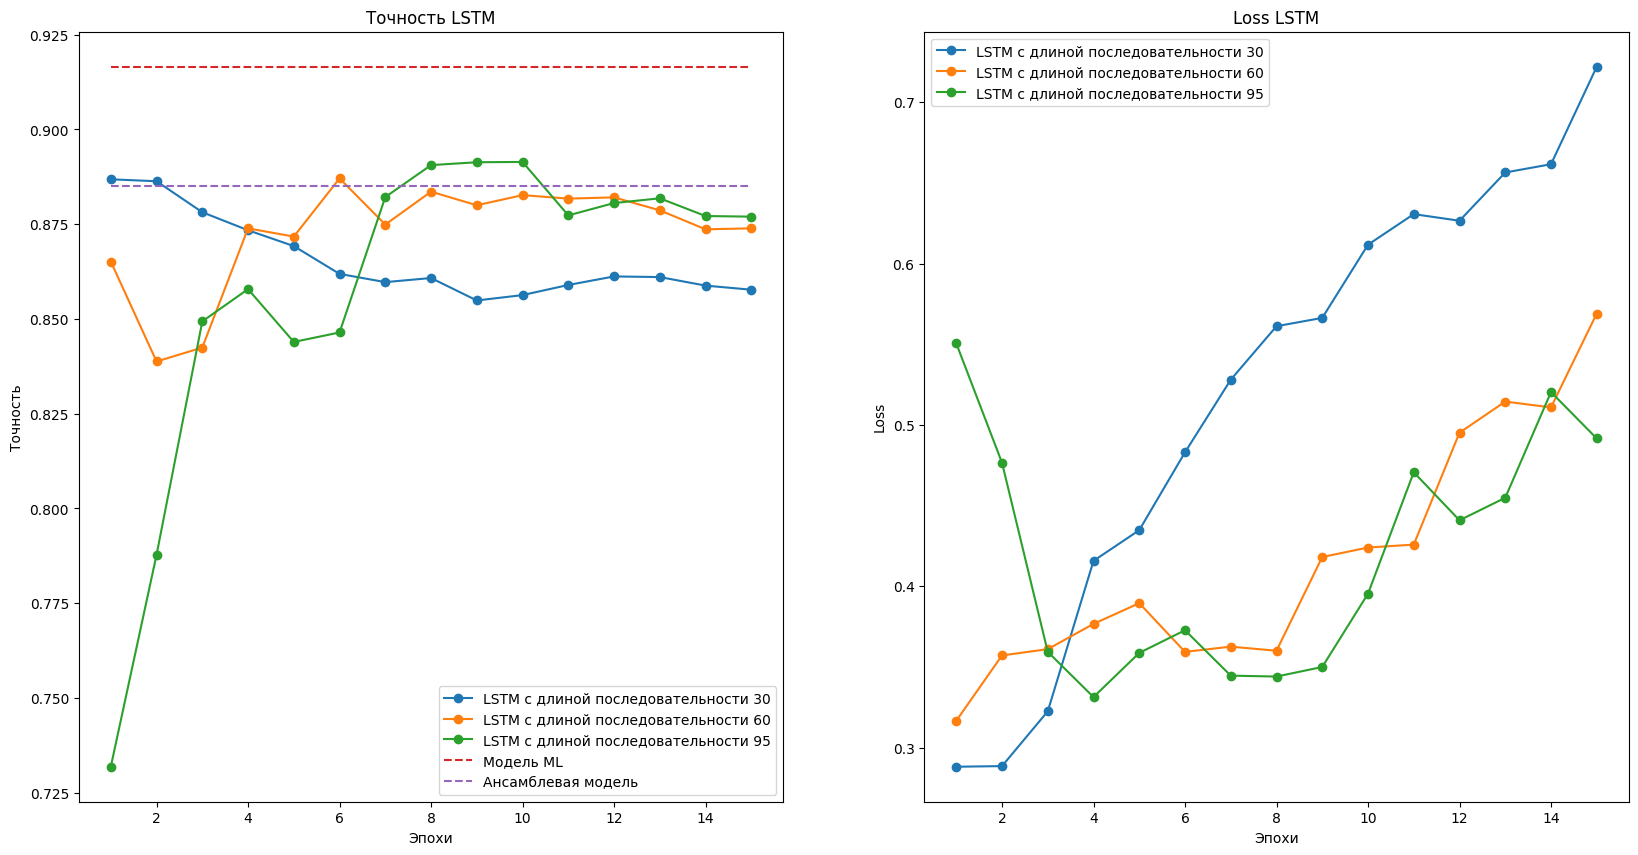

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(np.arange(1, 16), LSTM_acc[0], label="LSTM с длиной последовательности 30", marker='o')
ax[0].plot(np.arange(1, 16), LSTM_acc[1], label="LSTM с длиной последовательности 60", marker='o')
ax[0].plot(np.arange(1, 16), LSTM_acc[2], label="LSTM с длиной последовательности 95", marker='o')
ax[0].plot(np.arange(1, 16),[results['scores'][0]]*15, label = "Модель ML", linestyle='--')
ax[0].plot(np.arange(1, 16),[results['scores'][1]]*15, label = "Ансамблевая модель", linestyle='--')
ax[0].set_title('Точность LSTM')
ax[0].set_xlabel('Эпохи')
ax[0].set_ylabel('Точность')
ax[0].legend()
ax[1].plot(np.arange(1, 16), LSTM_loss[0], label="LSTM с длиной последовательности 30", marker='o')
ax[1].plot(np.arange(1, 16), LSTM_loss[1], label="LSTM с длиной последовательности 60", marker='o')
ax[1].plot(np.arange(1, 16), LSTM_loss[2], label="LSTM с длиной последовательности 95", marker='o')
ax[1].set_title('Loss LSTM')
ax[1].set_xlabel('Эпохи')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

*Обучение CNN*

In [ ]:
CNN_acc, CNN_loss = model_fit(x_train, y_train, create_CNN)

Длина последовательности:30
Номер текущего фолда: 1
-----------------------------------------------------------------
Номер текущего фолда: 2
-----------------------------------------------------------------
Номер текущего фолда: 3
-----------------------------------------------------------------
Номер текущего фолда: 4
-----------------------------------------------------------------
Номер текущего фолда: 5
-----------------------------------------------------------------
Длина последовательности:60
Номер текущего фолда: 1
-----------------------------------------------------------------
Номер текущего фолда: 2
-----------------------------------------------------------------
Номер текущего фолда: 3
-----------------------------------------------------------------
Номер текущего фолда: 4
-----------------------------------------------------------------
Номер текущего фолда: 5
-----------------------------------------------------------------
Длина последовательности:95
Номер текущего ф

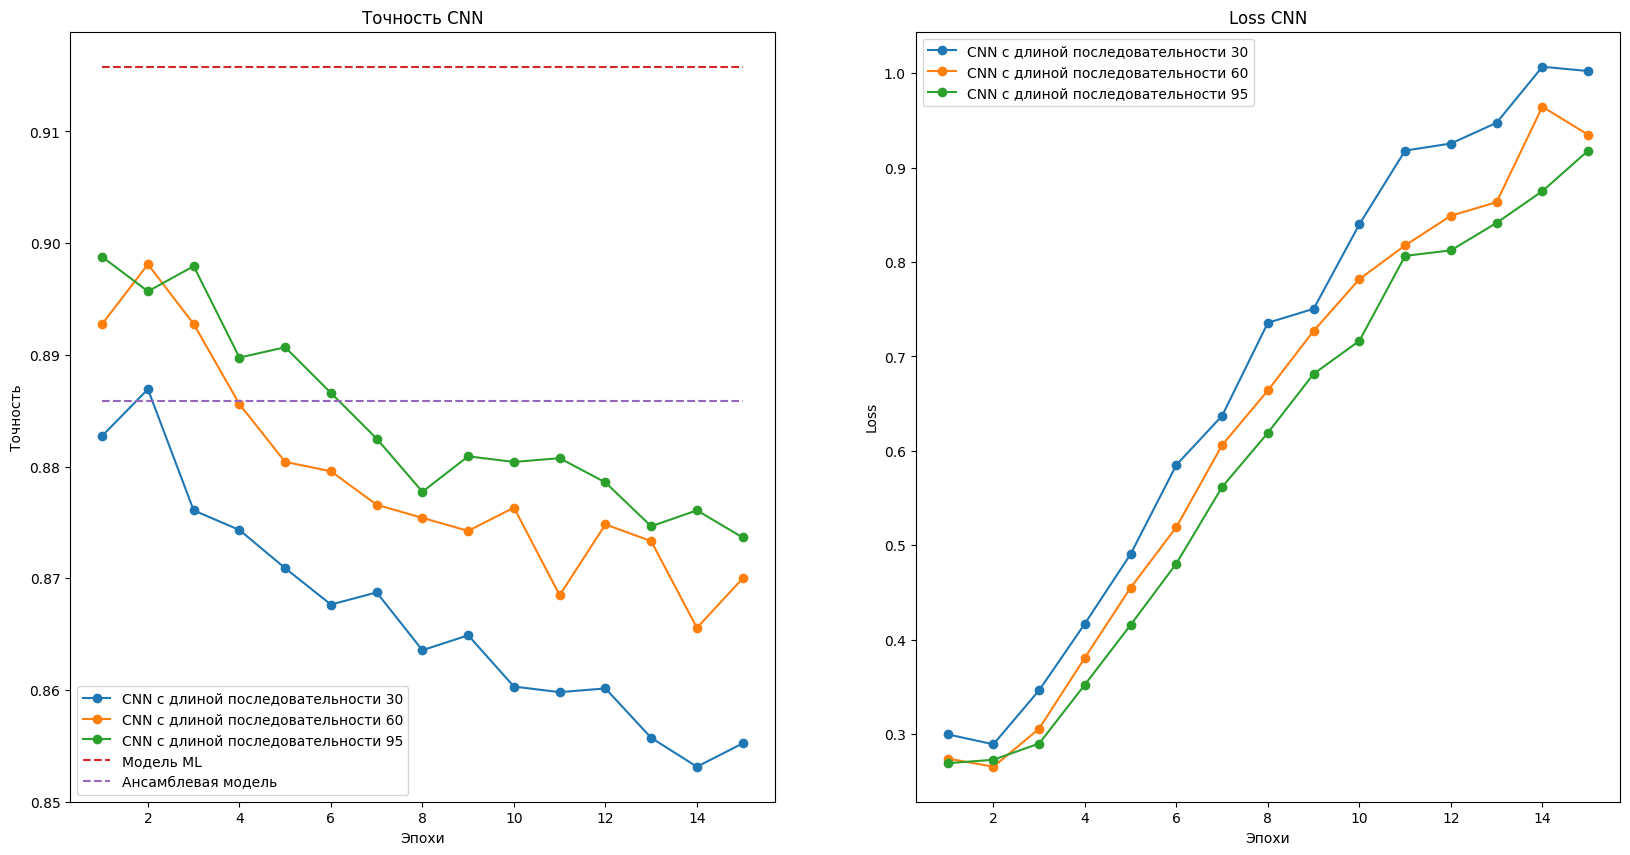

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(np.arange(1, 16), CNN_acc[0], label="CNN с длиной последовательности 30", marker='o')
ax[0].plot(np.arange(1, 16), CNN_acc[1], label="CNN с длиной последовательности 60", marker='o')
ax[0].plot(np.arange(1, 16), CNN_acc[2], label="CNN с длиной последовательности 95", marker='o')
ax[0].plot(np.arange(1, 16),[results['scores'][0]]*15, label = "Модель ML", linestyle='--')
ax[0].plot(np.arange(1, 16),[results['scores'][1]]*15, label = "Ансамблевая модель", linestyle='--')
ax[0].set_title('Точность CNN')
ax[0].set_xlabel('Эпохи')
ax[0].set_ylabel('Точность')
ax[0].legend()
ax[1].plot(np.arange(1, 16), CNN_loss[0], label="CNN с длиной последовательности 30", marker='o')
ax[1].plot(np.arange(1, 16), CNN_loss[1], label="CNN с длиной последовательности 60", marker='o')
ax[1].plot(np.arange(1, 16), CNN_loss[2], label="CNN с длиной последовательности 95", marker='o')
ax[1].set_title('Loss CNN')
ax[1].set_xlabel('Эпохи')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

# Тестирование

*Тестирование классической модели*

In [ ]:
start_time = time.time()
preds1 = results['models'][0].predict(x_test)
end_time = time.time()
ML_time = end_time-start_time
acc1 = accuracy_score(y_test, preds1)

*Тестирование ансамблевой модели*

In [ ]:
start_time = time.time()
preds2 = results['models'][1].predict(x_test)
end_time = time.time()
ensemble_time = end_time-start_time
acc2 = accuracy_score(y_test, preds2)

Тестирование LSTM

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
x_train_token = tokenizer.texts_to_sequences(x_train)
x_test_token = tokenizer.texts_to_sequences(x_test)

In [ ]:
x_train_LSTM = pad_sequences(x_train_token, maxlen=30, padding='post', truncating='post')
x_test_LSTM = pad_sequences(x_test_token, maxlen=30, padding='post', truncating='post')

In [ ]:
LSTM_model = create_LSTM(30)
LSTM_model.fit(x_train_LSTM, y_train, epochs=2)

Epoch 1/2
375/375 [==============================] - 42s 89ms/step - loss: 0.3460 - accuracy: 0.8611
Epoch 2/2
375/375 [==============================] - 33s 88ms/step - loss: 0.1781 - accuracy: 0.9362


In [ ]:
start_time = time.time()
LSTM_acc = LSTM_model.evaluate(x_test_LSTM, y_test)[1]
end_time = time.time()
LSTM_time = end_time - start_time

94/94 [==============================] - 2s 21ms/step - loss: 0.2935 - accuracy: 0.8772


Тестирование CNN

In [ ]:
x_train_CNN = pad_sequences(x_train_token, maxlen=95, padding='post', truncating='post')
x_test_CNN = pad_sequences(x_test_token, maxlen=95, padding='post', truncating='post')

In [ ]:
CNN_model = create_CNN(95)
CNN_model.fit(x_train_CNN, y_train, epochs=3)

Epoch 1/3
375/375 [==============================] - 24s 61ms/step - loss: 0.3790 - accuracy: 0.8469
Epoch 2/3
375/375 [==============================] - 24s 65ms/step - loss: 0.2029 - accuracy: 0.9330
Epoch 3/3
375/375 [==============================] - 23s 60ms/step - loss: 0.1152 - accuracy: 0.9655


In [ ]:
start_time = time.time()
CNN_acc = CNN_model.evaluate(x_test_CNN, y_test)[1]
end_time = time.time()
CNN_time = end_time-start_time

94/94 [==============================] - 1s 14ms/step - loss: 0.2853 - accuracy: 0.8935


# Сравнение моделей

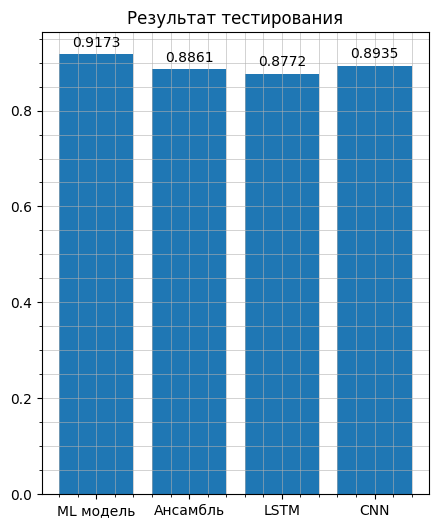

In [ ]:
labels = ['ML модель', 'Ансамбль', 'LSTM', 'CNN']
scores = [results['scores'][0], results['scores'][1], LSTM_acc, CNN_acc]
plt.figure(figsize=(5, 6))
bars = plt.bar(labels, scores)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4),
             ha='center', va='bottom')
plt.title("Результат тестирования")
plt.grid(which="major", linewidth=0.4)
plt.grid(which="minor", linewidth=0.4)
plt.minorticks_on()
plt.show()

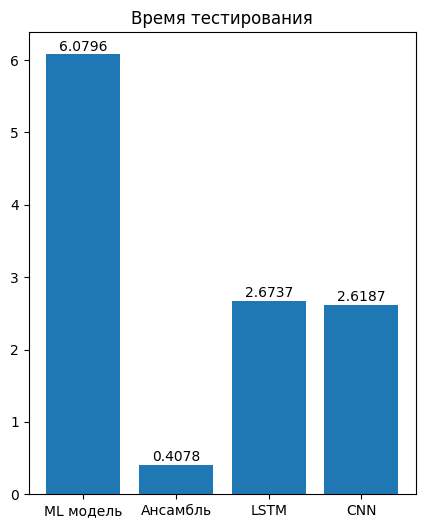

In [ ]:
plt.figure(figsize=(5, 6))
bars = plt.bar(labels, [ML_time, ensemble_time, LSTM_time, CNN_time])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4),
             ha='center', va='bottom')
plt.title("Время тестирования")
plt.show()